In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys
import types
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from gluonts.dataset.repository import dataset_recipes, get_dataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, locally_linear_embedding
from sklearn.metrics.pairwise import euclidean_distances
from torch.utils.data import DataLoader
from datasets import load_from_disk


def seed_everything(seed: int):
    import os
    import random

    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

sys.path.append("../")
from probts.data.data_manager import DataManager
from probts.data.lotsa_datasets import LotsaTSDatasetLoader

In [2]:
# load_model
from probts.model.forecaster.prob_forecaster.moirai import Moirai

moirai = Moirai(target_dim=1, context_length=96, prediction_length=96, freq='H', lags_list=[], patch_size=32, variate_mode='S', model_size='small')

data_manager = DataManager("traffic_nips", history_length=96, context_length=96, prediction_length=96, scaler='none')
data_loader = DataLoader(data_manager.test_iter_dataset, batch_size=1)

pred, emb = moirai.embedding(types.SimpleNamespace(**next(iter(data_loader))))
print(pred.shape)
print(emb.shape)

2024-09-18 15:10:44.047269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


Loading Short-term Datasets: traffic_nips
context_length: 96, prediction_length: 96
torch.Size([96, 1, 963])
torch.Size([1, 6, 384, 963])


# load LOTSA-v1 data

In [26]:
# test lotsa_datasets.py
# LOTSA_PATH = "/data/Blob_EastUS/v-zhenwzhang/tsfm_datasets/lotsa_data"
# dataset = load_from_disk(Path(LOTSA_PATH) / "uber_tlc_hourly")

LOTSA_PATH = "/data/Blob_EastUS/v-zhenwzhang/tsfm_datasets/lotsa_data"

dataset = LotsaTSDatasetLoader(
    # dataset="uber_tlc_hourly",
    dataset="BEIJING_SUBWAY_30MIN",
    path=LOTSA_PATH,
    context_length=512,
    history_length=512,
    prediction_length=96,
    scaler="none",
)
data = next(iter(dataset.get_iter_dataset("train")))
print(data["past_target_cdf"].shape)

update target_dim: 552


# get MOIRAI embeddings

In [3]:
LOTSA_PATH = "/data/Blob_EastUS/v-zhenwzhang/tsfm_datasets/lotsa_data"

def get_data(dataloader):
    data = next(iter(dataloader))
    return data

datasets_libcity = [
    "BEIJING_SUBWAY_30MIN",
    "HZMETRO",
    "PEMS03",
    "PEMS04",
    "PEMS07",
    "PEMS08",
]
datasets_buildings_bench = [
    "bdg-2_panther",
    "bdg-2_fox",
    "bdg-2_rat",
    "bdg-2_bear",
    "sceaux",
    "borealis",
    "ideal",
    "smart",
]

datasets_proenfo = ["gfc12_load", "gfc17_load", "bull", "hog", "gfc14_load", "spain", "pdb", "covid19_energy"]
ltsf_datasets = ["ettm1", "etth1"]

datasets = datasets_libcity + datasets_proenfo + datasets_buildings_bench
dataloaders = {
    dataset: DataLoader(
        LotsaTSDatasetLoader(
            dataset=dataset,
            path=LOTSA_PATH,
            context_length=512,
            history_length=512,
            prediction_length=96,
            scaler="none",
        ).get_iter_dataset("train"),
        batch_size=1,
    )
    for dataset in datasets
}

dataloaders.update(
    {
        dataset: DataLoader(
            DataManager(
                dataset,
                history_length=512,
                context_length=512,
                prediction_length=96,
                scaler="none",
                path="../datasets"
            ).test_iter_dataset,
            batch_size=1,
        )
        for dataset in ltsf_datasets
    }
)

data_dict = {
    dataset: {"train_data": get_data(dataloaders[dataset])} for dataset in dataloaders
}

for dataset in dataloaders:
    print(dataset, data_dict[dataset]["train_data"]["past_target_cdf"].shape)

# load_model
from probts.model.forecaster.prob_forecaster.moirai import Moirai

moirai = Moirai(
    target_dim=1,
    context_length=512,
    prediction_length=96,
    freq="H",
    lags_list=[],
    patch_size=64,
    variate_mode="S",
    model_size="large",
)

for key in data_dict:
    print("MOIRAI: ", key)
    pred, emb = moirai.embedding(types.SimpleNamespace(**data_dict[key]["train_data"]))
    data_dict[key].update(
        {"pred": pred.cpu().detach().numpy(), "emb": emb.cpu().detach().numpy()}
    )

update target_dim: 552
update target_dim: 160
update target_dim: 358
update target_dim: 921
update target_dim: 883
update target_dim: 510
update target_dim: 20
update target_dim: 8
update target_dim: 41
update target_dim: 24
update target_dim: 1
update target_dim: 1
update target_dim: 1
update target_dim: 1
update target_dim: 105
update target_dim: 135
update target_dim: 280
update target_dim: 91
update target_dim: 1
update target_dim: 15
update target_dim: 217
update target_dim: 5
Loading Long-term Datasets: ettm1
num_test_dates:  120
num_test_dates:  120
context_length: 512, prediction_length: 96
Loading Long-term Datasets: etth1
num_test_dates:  30
num_test_dates:  30
context_length: 512, prediction_length: 96
BEIJING_SUBWAY_30MIN torch.Size([1, 512, 552])
HZMETRO torch.Size([1, 512, 160])
PEMS03 torch.Size([1, 512, 358])
PEMS04 torch.Size([1, 512, 921])
PEMS07 torch.Size([1, 512, 883])
PEMS08 torch.Size([1, 512, 510])
gfc12_load torch.Size([1, 512, 20])
gfc17_load torch.Size([1, 51

2024-09-09 14:51:26.521577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


MOIRAI:  BEIJING_SUBWAY_30MIN
MOIRAI:  HZMETRO
MOIRAI:  PEMS03
MOIRAI:  PEMS04
MOIRAI:  PEMS07
MOIRAI:  PEMS08
MOIRAI:  gfc12_load
MOIRAI:  gfc17_load
MOIRAI:  bull
MOIRAI:  hog
MOIRAI:  gfc14_load
MOIRAI:  spain
MOIRAI:  pdb
MOIRAI:  covid19_energy
MOIRAI:  bdg-2_panther
MOIRAI:  bdg-2_fox
MOIRAI:  bdg-2_rat
MOIRAI:  bdg-2_bear
MOIRAI:  sceaux
MOIRAI:  borealis
MOIRAI:  ideal
MOIRAI:  smart
MOIRAI:  ettm1
MOIRAI:  etth1


In [4]:
def get_embeddings_data(data_dict):
    all_datasets = data_dict.keys()
    univariate_embeddings = []
    univariate_data = []
    dataset_idxs = []
    for i, key in enumerate(data_dict):
        num_of_univariate = data_dict[key]["emb"].shape[0]
        # print(data_dict[key]["emb"].shape)
        for j in range(num_of_univariate):
            univariate_embeddings.append(data_dict[key]["emb"][j, :, :].reshape(-1))
            univariate_data.append(data_dict[key]["train_data"]['past_target_cdf'][:, :, j].reshape(-1))
            dataset_idxs.append(i)
    univariate_embeddings = np.stack(univariate_embeddings)
    univariate_data = np.stack(univariate_data)
    dataset_idxs = np.array(dataset_idxs)
    return univariate_embeddings, univariate_data, dataset_idxs, all_datasets

embeddings, univariate_data, dataset_idxs, all_datasets = get_embeddings_data(data_dict)

In [5]:
for dataset in data_dict:
    # get dataset-level embeddings
    dataset_emb = data_dict[dataset]["emb"].mean(axis=0)
    data_dict[dataset].update({"dataset_emb": dataset_emb})

In [6]:
data_dict["hog"]["dataset_emb"].shape

(10, 1024)

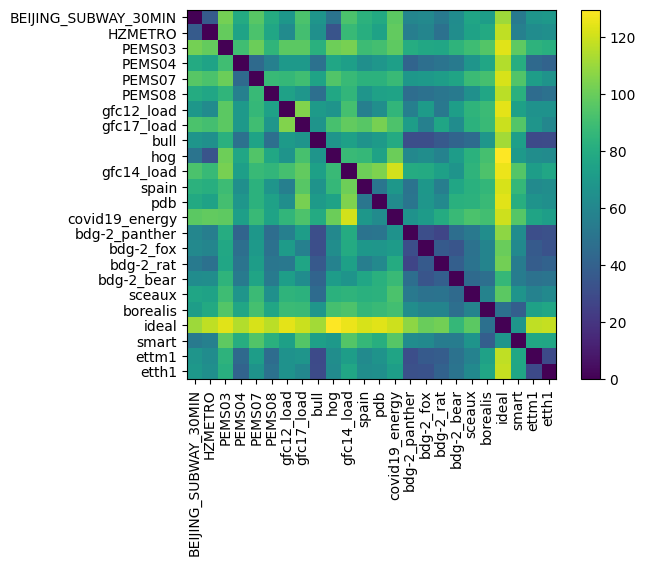

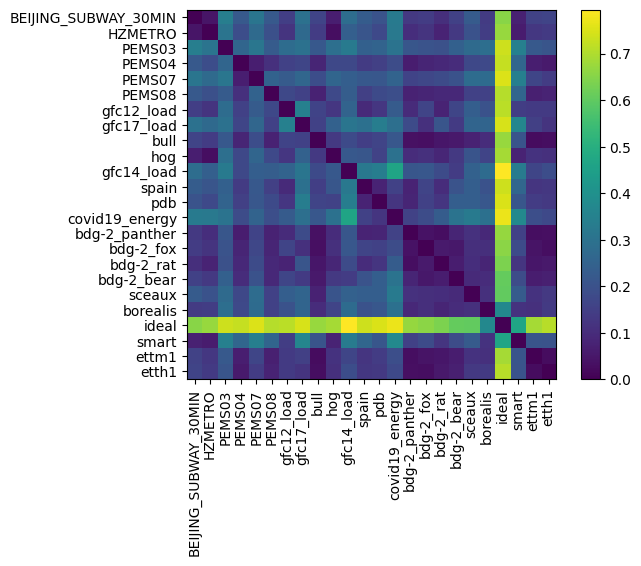

In [7]:
# get dataset-level embeddings distance matrix
dataset_emb = np.stack([data_dict[dataset]["dataset_emb"].reshape(-1) for dataset in data_dict])
dataset_emb_dist_euc = euclidean_distances(dataset_emb, dataset_emb)
# cosine similarity
from sklearn.metrics.pairwise import cosine_distances
dataset_emb_dist_cos = cosine_distances(dataset_emb)

# visualize dataset-level embeddings distance matrix
plt.imshow(dataset_emb_dist_euc)
plt.colorbar()
plt.xticks(range(len(data_dict)), data_dict.keys(), rotation=90)
plt.yticks(range(len(data_dict)), data_dict.keys())
plt.show()

plt.imshow(dataset_emb_dist_cos)
plt.colorbar()
plt.xticks(range(len(data_dict)), data_dict.keys(), rotation=90)
plt.yticks(range(len(data_dict)), data_dict.keys())
plt.show()

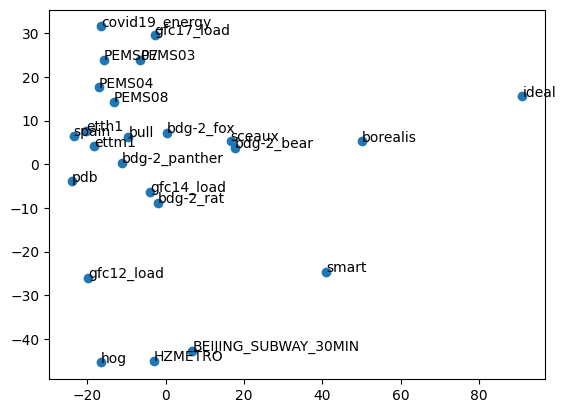

In [8]:
# visualize dataset-level embeddings
pca = PCA(n_components=2)
dataset_embs = np.stack([data_dict[key]["dataset_emb"].reshape(-1) for key in data_dict])
dataset_embs_pca = pca.fit_transform(dataset_embs)
plt.scatter(dataset_embs_pca[:, 0], dataset_embs_pca[:, 1])
for i, txt in enumerate(all_datasets):
    plt.annotate(txt, (dataset_embs_pca[i, 0], dataset_embs_pca[i, 1]))

In [19]:
# 假设 dataset_idxs 的类别数是 len(all_datasets)
def visualize_tsne(embeddings, dataset_idxs, all_datasets):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)

    plt.figure(figsize=(15, 15))

    # 获取20种颜色, 'tab20' 是一个适合区分类别的颜色映射表
    cmap = plt.get_cmap('tab20', len(all_datasets))

    for i, dataset in enumerate(all_datasets):
        idxs = dataset_idxs == i
        plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=dataset, color=cmap(i))
    
    plt.legend()
    plt.show()

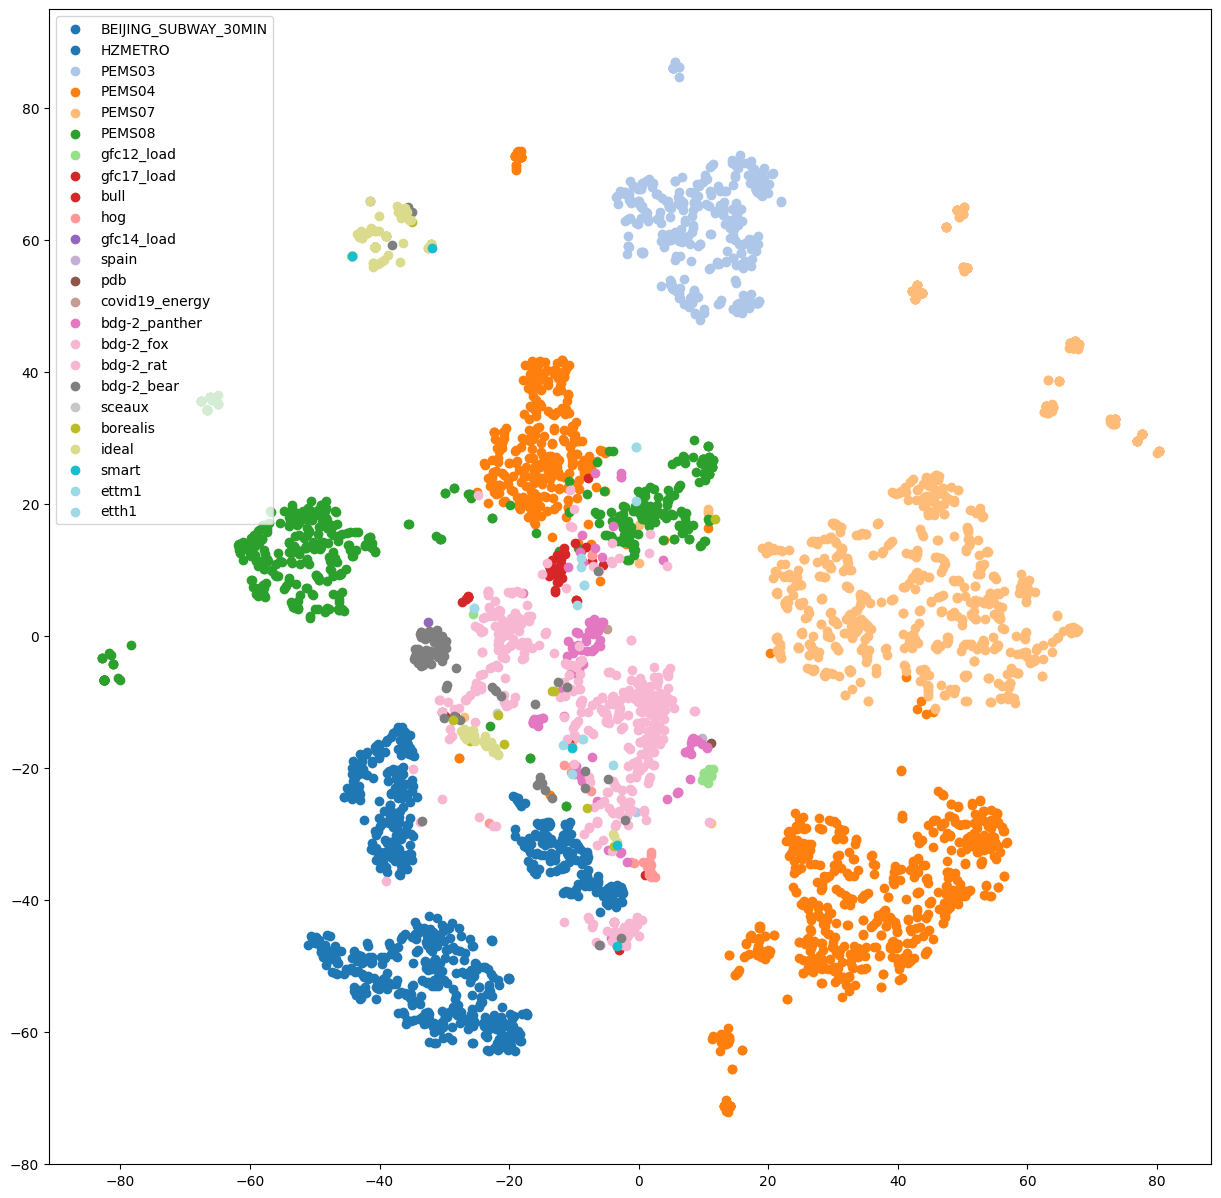

In [20]:
visualize_tsne(embeddings, dataset_idxs, all_datasets)

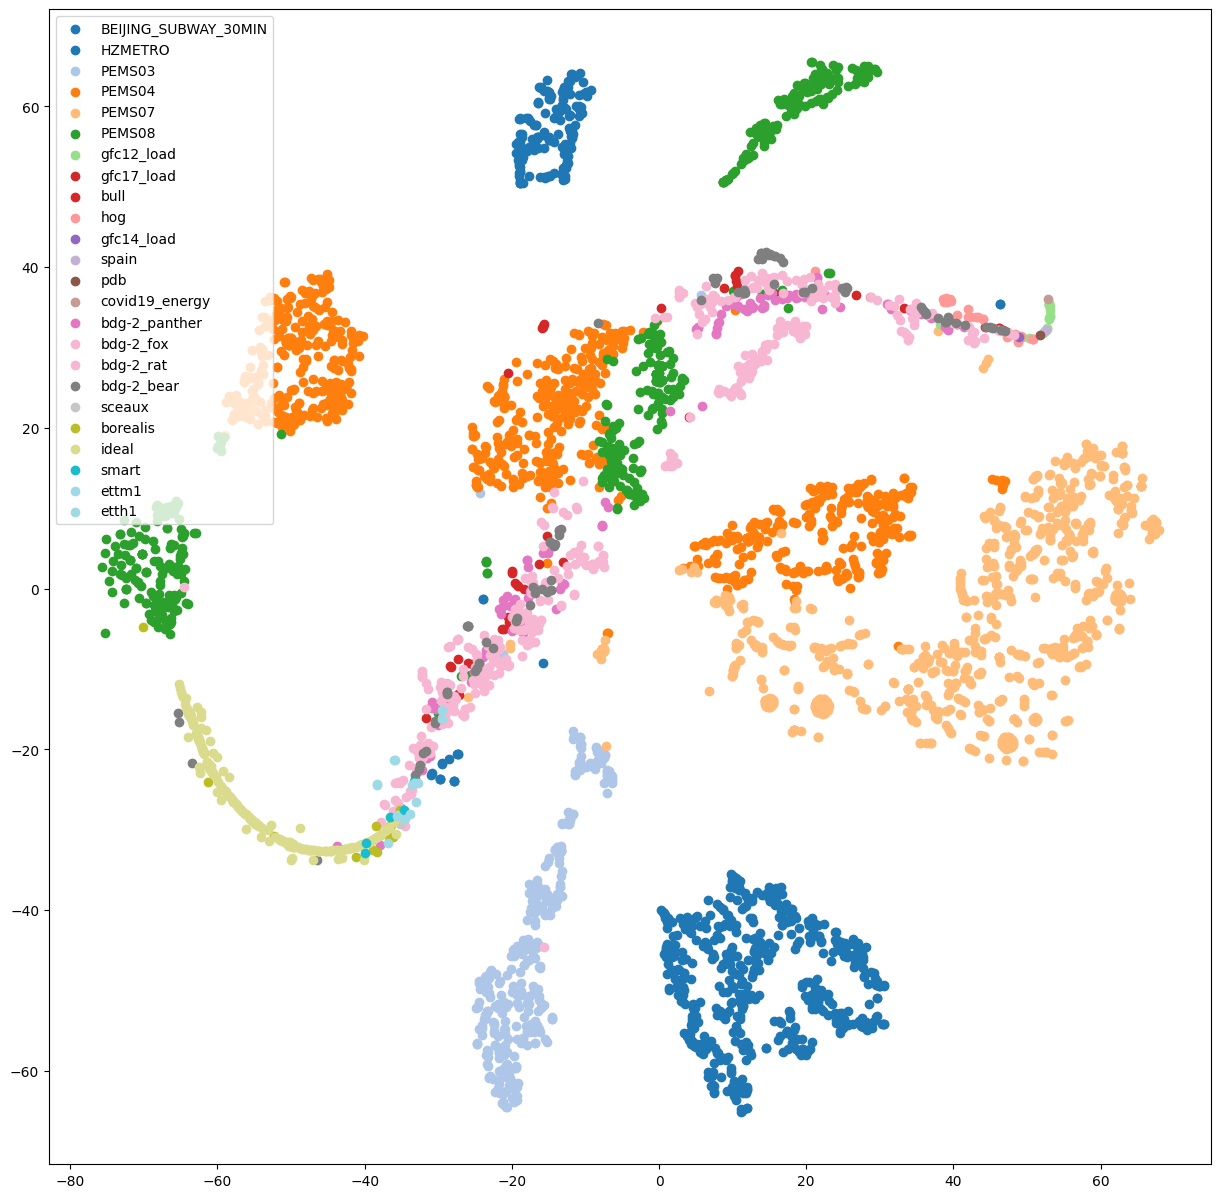

In [21]:
visualize_tsne(univariate_data, dataset_idxs, all_datasets)